<a href="https://colab.research.google.com/github/npk08/AI-ML-Project-Bank-Customer-Churn/blob/main/AI_ML_Nice_Project_Bank_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive

#1.โหลด Dataset จาก Google Drive
drive.mount('/content/drive')

#2.เลือกไฟล์ให้ถูกต้อง
file_path = '/content/drive/MyDrive/Customer-Churn-Records.csv'
print(f"\nAttempting to load data from: {file_path}")

#3.โหลดข้อมูล
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully from Google Drive.")
except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
    print("Please check the file path and ensure the file 'Customer-Churn-Records.csv' is in your Google Drive.")
    raise

#4.ตรวจสอบข้อมูลเบื่่องต้น
print("\n--- ข้อมูลเบื้องต้น (Head) ---")
pd.set_option('display.max_columns', None)
print(df.head())

print("\n--- โครงสร้างข้อมูล (Info) ---")
df.info()

print("\n--- สถิติสรุป (Describe) ---")
print(df.describe())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Attempting to load data from: /content/drive/MyDrive/Customer-Churn-Records.csv
Dataset loaded successfully from Google Drive.

--- ข้อมูลเบื้องต้น (Head) ---
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3 


--- สถิติของคอลัมน์สำคัญ ---
        CreditScore           Age        Tenure        Balance  \
count  10000.000000  10000.000000  10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288   
std       96.653299     10.487806      2.892174   62397.405202   
min      350.000000     18.000000      0.000000       0.000000   
25%      584.000000     32.000000      3.000000       0.000000   
50%      652.000000     37.000000      5.000000   97198.540000   
75%      718.000000     44.000000      7.000000  127644.240000   
max      850.000000     92.000000     10.000000  250898.090000   

       EstimatedSalary  
count     10000.000000  
mean     100090.239881  
std       57510.492818  
min          11.580000  
25%       51002.110000  
50%      100193.915000  
75%      149388.247500  
max      199992.480000  

--- สัดส่วนลูกค้าที่ 'เลิกใช้งาน' (Exited) ---
Exited
0    79.62%
1    20.38%
Name: proportion, dtype: object


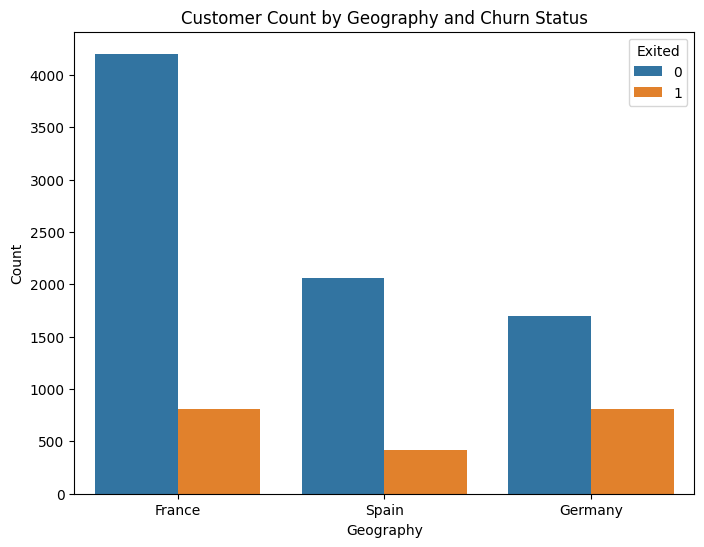

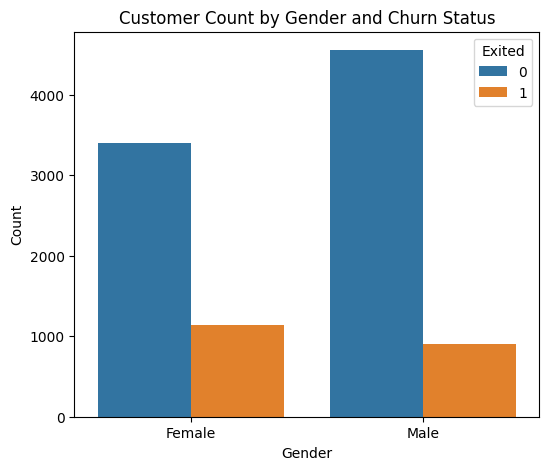

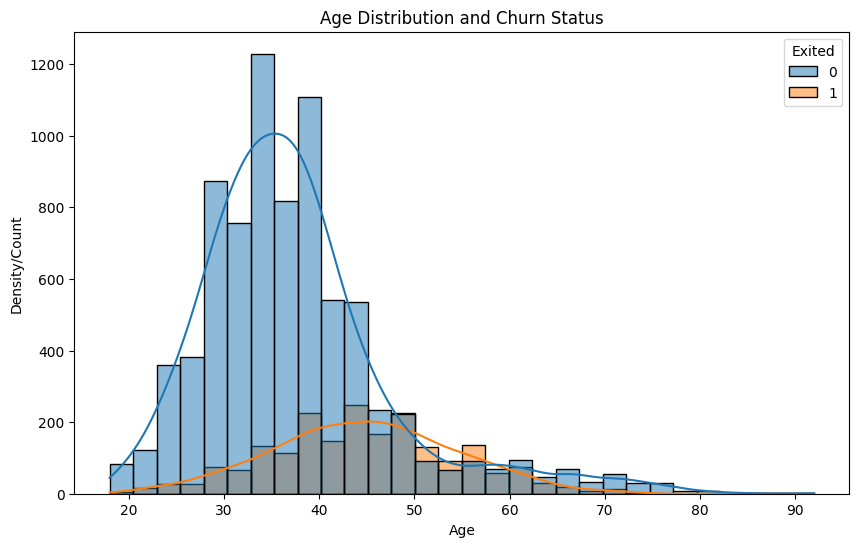

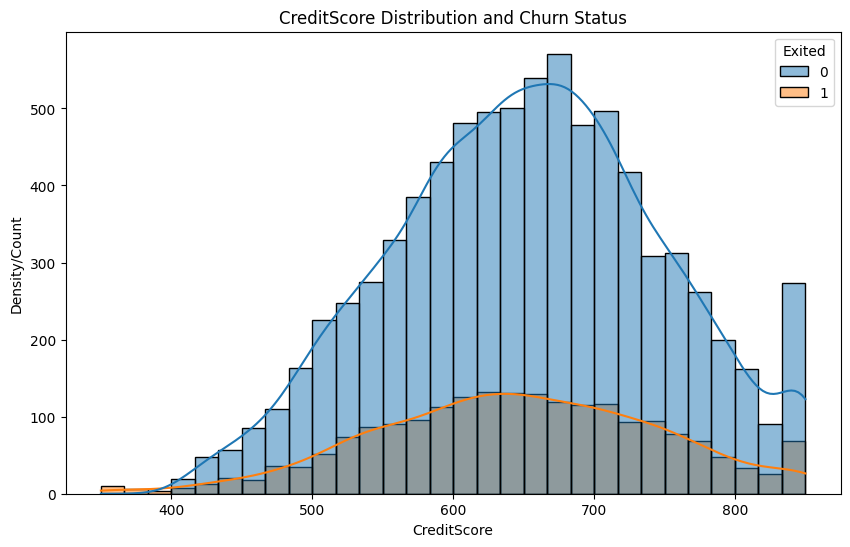

In [13]:
#การทำEDA
print("\n--- สถิติของคอลัมน์สำคัญ ---")
print(df[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']].describe())

churn_rate = df['Exited'].value_counts(normalize=True) * 100
print("\n--- สัดส่วนลูกค้าที่ 'เลิกใช้งาน' (Exited) ---")
print(churn_rate.apply(lambda x: f'{x:.2f}%'))

#0คือไม่เลิกใช้งาน, 1คือเลิกใช้งาน

#Data Visualization
#1.การVisualization:สัดส่วนลูกค้าตามประเทศ
plt.figure(figsize=(8, 6))
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Customer Count by Geography and Churn Status')
plt.xlabel('Geography')
plt.ylabel('Count')
plt.show() #

#2.การVisualization:สัดส่วนลูกค้าตามเพศ
plt.figure(figsize=(6, 5))
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title('Customer Count by Gender and Churn Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show() #

#3.การVisualization:การกระจายของอายุ
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Exited', bins=30, kde=True)
plt.title('Age Distribution and Churn Status')
plt.xlabel('Age')
plt.ylabel('Density/Count')
plt.show() #

# 4.การVisualization:การกระจายของCredit Score
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='CreditScore', hue='Exited', bins=30, kde=True)
plt.title('CreditScore Distribution and Churn Status')
plt.xlabel('CreditScore')
plt.ylabel('Density/Count')
plt.show()

In [14]:
#3การตรวจและจัดการข้อมูลที่ผิดหรือขาดหาย
print("\n--- ตรวจสอบ Missing Values ---")
print(df.isnull().sum())

#เลือกColumnมาใช้งาน
#ตัดคอลัมน์ที่ไม่จำเป็นออก
df_processed = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#แยกFeatures(X)และTarget(y)
X = df_processed.drop('Exited', axis=1)
y = df_processed['Exited'] # Target: ลูกค้าได้เลิกใช้งานไปหรือยัง (Yes/No)

print("\n--- คอลัมน์ Features ที่เลือกใช้ ---")
print(X.columns.tolist())

#การPreprocessing(Scaling และ Encoding)
#แยกคอลัมน์ตามประเภท
categorical_features = ['Geography', 'Gender', 'Card Type', 'Satisfaction Score', 'Complain']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Point Earned']

#สร้างPreprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# 4. การแบ่งข้อมูลเป็น Training และ Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


--- ตรวจสอบ Missing Values ---
RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

--- คอลัมน์ Features ที่เลือกใช้ ---
['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Complain', 'Satisfaction Score', 'Card Type', 'Point Earned']

Training set size: 8000 samples
Testing set size: 2000 samples



--- Training Model (Random Forest) ---
Training complete.

--- ผลการประเมินโมเดล (Classification Report) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


--- Confusion Matrix ---


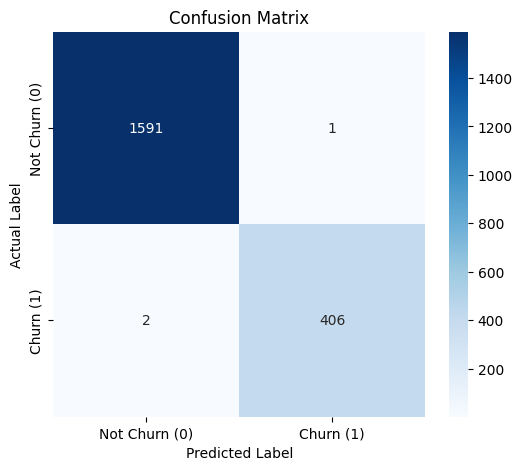


Accuracy: 0.9985


In [15]:
#4.การสร้าง Pipeline และ Training Model
#ใช้ Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

#สร้างPipeline:Preprocessing > Model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

#Training Model
print("\n--- Training Model (Random Forest) ---")
pipeline.fit(X_train, y_train)
print("Training complete.")

#การทำนายผลบน Test Set
y_pred = pipeline.predict(X_test)

# 4.2 การแสดงผลการเทรนและวิเคราะห์ผลลัพธ์ (Evaluation)
print("\n--- ผลการประเมินโมเดล (Classification Report) ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn (0)', 'Churn (1)'],
            yticklabels=['Not Churn (0)', 'Churn (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show() #

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

In [16]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import recall_score, roc_auc_score

#1.สร้าง Pipeline ที่รวม Preprocessor และ SMOTE
#SMOTE ต้องใช้กับข้อมูลที่ถูก Preprocess แล้ว
#ทำ Preprocessing ด้วย ColumnTransformer
X_train_processed = preprocessor.fit_transform(X_train)

#ต้องแปลงคอลัมน์ที่ได้จาก OneHotEncoder ให้กลับไปเป็น DataFrame เพื่อให้ SMOTE ทำงานง่าย
#เนื่องจาก ColumnTransformer ใช้ sparse_output=False เลยได้ numpy array
#สามารถใช้ SMOTE กับ numpy array ได้โดยตรง
print("\n--- Applying SMOTE (Oversampling Minority Class) ---")

#ใช้SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Resampled training data shape: {X_train_res.shape}")
print(f"Resampled Churn count (1): {y_train_res.value_counts()[1]}")
print(f"Resampled Non-Churn count (0): {y_train_res.value_counts()[0]}")

#2.Training Model ใหม่ด้วย Resampled Data
smote_model = RandomForestClassifier(n_estimators=100, random_state=42) # ไม่ต้องใช้ class_weight='balanced' แล้ว
smote_model.fit(X_train_res, y_train_res)

#Preprocess X_test (ใช้ fit_transform ของ preprocessor เดิม)
X_test_processed = preprocessor.transform(X_test)
y_pred_smote = smote_model.predict(X_test_processed)

#3.ประเมิน
print("\n--- ผลการประเมินโมเดล (Random Forest + SMOTE) ---")
print(classification_report(y_test, y_pred_smote))

#เน้นที่ Recall ของ Class 1 (Churn)
recall_1 = recall_score(y_test, y_pred_smote, pos_label=1)
print(f"Recall for Churn (1): {recall_1:.4f}")


--- Applying SMOTE (Oversampling Minority Class) ---
Original training data shape: (8000, 14)
Resampled training data shape: (12740, 25)
Resampled Churn count (1): 6370
Resampled Non-Churn count (0): 6370

--- ผลการประเมินโมเดล (Random Forest + SMOTE) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Recall for Churn (1): 0.9951


In [17]:
!pip install xgboost

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#1.สร้าง Pipeline สำหรับ XGBoost
#XGBoost จะให้ผลลัพธ์ที่ดีที่สุดเมื่อใช้ข้อมูลที่ Scaled แล้ว
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', #สำหรับปัญหา Binary Classification
    n_estimators=100,
    random_state=42,
    #สัดส่วน:จำนวน Non-Churn/จำนวน Churn
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]
)

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb_model)])

# 2. Training Model
print("\n--- Training Model (XGBoost) ---")
xgb_pipeline.fit(X_train, y_train)
print("Training complete.")

# 3. การทำนายและประเมินผล
y_pred_xgb = xgb_pipeline.predict(X_test)

print("\n--- ผลการประเมินโมเดล (XGBoost) ---")
print(classification_report(y_test, y_pred_xgb))


--- Training Model (XGBoost) ---
Training complete.

--- ผลการประเมินโมเดล (XGBoost) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [22]:
from sklearn.model_selection import GridSearchCV

#1.กำหนด Hyperparameters ที่ต้องการลอง
#Tuning บน XGBoost Model ที่อยู่ใน Pipeline
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
}

#2.สร้าง GridSearchCV
#ใช้'recall' หรือ 'roc_auc' เป็น scoring metric ที่เหมาะสมกว่า Accuracy สำหรับ Imbalanced Data
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)

#3.รัน Grid Search บน Training Data
print("\n--- Running Grid Search for XGBoost Tuning ---")
grid_search.fit(X_train, y_train)

#4.ผลลัพธ์
print(f"\nBest Parameters Found: {grid_search.best_params_}")
print(f"Best Recall Score (Class 1): {grid_search.best_score_:.4f}")

#5.ใช้โมเดลทำนายผล
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("\n--- ผลการประเมินโมเดล (XGBoost Tuned) ---")
print(classification_report(y_test, y_pred_tuned))


--- Running Grid Search for XGBoost Tuning ---
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Parameters Found: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best Recall Score (Class 1): 0.9988

--- ผลการประเมินโมเดล (XGBoost Tuned) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000




--- การวิเคราะห์ปัจจัยสำคัญ (Feature Importance) ---
                   Feature  Importance
23         cat__Complain_0    0.997412
10  cat__Geography_Germany    0.000787
7     num__EstimatedSalary    0.000787
1                 num__Age    0.000492
2              num__Tenure    0.000489
8        num__Point Earned    0.000032
3             num__Balance    0.000000
4       num__NumOfProducts    0.000000
0         num__CreditScore    0.000000
5           num__HasCrCard    0.000000


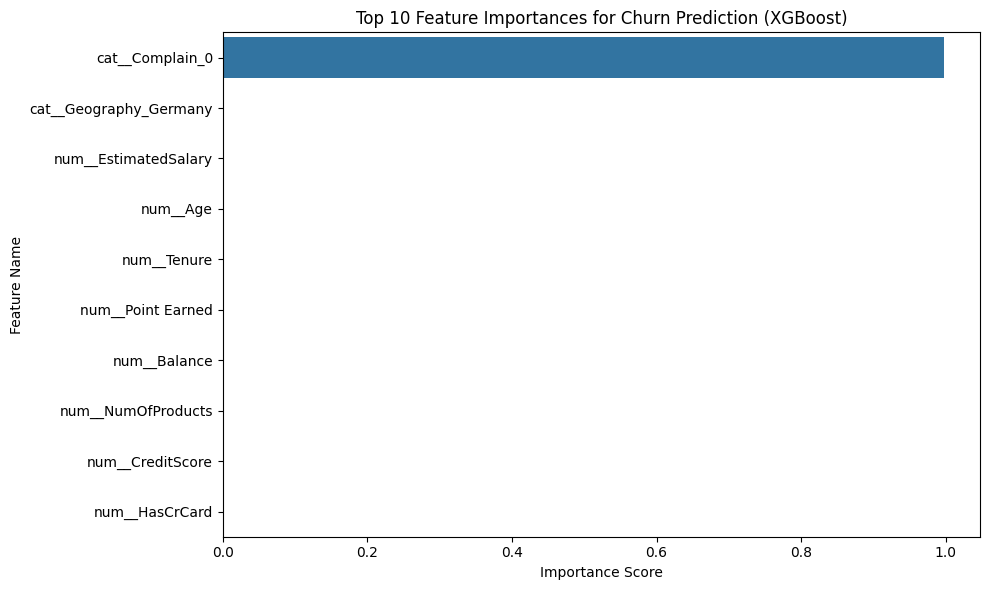

In [23]:
print("\n--- การวิเคราะห์ปัจจัยสำคัญ (Feature Importance) ---")

#1.ดึง XGBoost Model ออกจาก Pipeline
best_xgb = best_model.named_steps['classifier']

#2.ดึงชื่อ Feature ทั้งหมด (รวมถึงที่ถูก One-Hot Encoder แล้ว)
# Preprocessor จะสร้างชื่อ Feature ที่รวมกับชื่อคอลัมน์เดิม + ค่า (เช่น Geography__Germany)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

#3. สร้าง DataFrame เพื่อแสดงความสำคัญ
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

#4. แสดงผล Top 10 Features
print(importance_df.head(10))

#5. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances for Churn Prediction (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

In [20]:
import joblib
joblib.dump(best_model, 'best_churn_model.pkl')

['best_churn_model.pkl']